# 使用LSTM来进行序列预测

在本文中，尝试使用LSTM来进行简单的序列预测——sin函数的序列预测


In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
# generate data of sin funcion
x = np.linspace(0, 100, 10000)
y = np.sin(x)

plt.plot(x,y)

In [3]:
hidden_size = 200
keep_prob = 0.5
batch_size = 100
TIMESTEPS = 10


In [4]:
sess = tf.Session()

In [5]:
X = tf.placeholder(dtype=tf.float32, shape=[None,TIMESTEPS,1])
y = tf.placeholder(dtype= tf.float32,shape = [None,1])
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=1.0, state_is_tuple=True)
lstm_cell1 = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
#init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
outputs, state = tf.nn.dynamic_rnn(lstm_cell1, inputs=X, dtype=tf.float32,time_major=False)
h_state = outputs[:, -1, :] #[batch_size, hidden_size]

W = tf.Variable(tf.truncated_normal([hidden_size,1], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[1]), dtype=tf.float32)
y_pre = tf.matmul(h_state, W) + bias
loss = tf.reduce_mean(tf.square(tf.subtract(y,y_pre)))

optimizer = tf.train.AdamOptimizer(0.05)

train_op = optimizer.minimize(loss)

    


In [6]:
def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [2, 3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)

def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test


def prepare_data(data, time_steps, labels=False, val_size=0.1, test_size=0.1):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))


def generate_data(fct, x, time_steps, seperate=False):
    """generates data with based on a function fct"""
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, val_y, test_y = prepare_data(data['b'] if seperate else data, time_steps,labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

In [7]:
X_vals, y_vals = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)

In [8]:
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
losses = []
for i in range(10000):
    batch_index = np.random.choice(8090,100)
    X_batch = X_vals["train"][batch_index]   
    y_batch = y_vals['train'][batch_index]
    loss_val,_ = sess.run([loss,train_op],feed_dict={X:X_batch,y:y_batch})
    losses.append(loss_val)

In [11]:
print losses[-1]

0.00584684


In [12]:
ys  =[]
xs = []
for i in range(len(X_vals["test"])):
    x_inputs = np.expand_dims(X_vals['test'][i],axis = 0)
    xs.append(x_inputs[0,-1,0])
    y_pred = sess.run(y_pre,feed_dict={X:x_inputs})
    ys.append(y_pred)

In [13]:
ys = np.array(ys).squeeze()

In [14]:
ys.shape

(990,)

In [16]:
xs = np.linspace(0,10,990)

In [17]:
print len(xs)

990


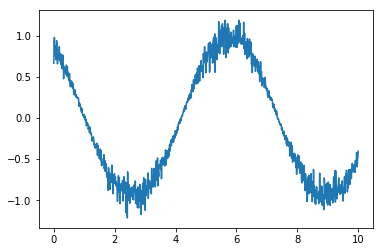

In [19]:
#plt.xlim(0,5)
plt.plot(xs,ys)